# Elevator simulation

In [0]:
# import relevant libraries

import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm, rc
from matplotlib import animation
from google.colab import files



In [0]:
class Elevator(object):
  
  '''
    An elevator class
    
    Attributes:
    in_elevator_passenger_list- a list of passenger objects
    capacity - an integer that defines the maximum capacity of the elevator
    base_floor- the default stationary floor
    current_floor-an integer that states which floor is the elevator currently in
    direction- an integer that indicates idle, up, or down using 0,1, 
      or -1 respectively.
    current_destination- an integer states the current goal floor 
    doos_open- a flag that indicates if the doors of the elevator are open
      or closed
  '''
    
    
  UP=1
  DOWN=-1
  IDLE=0
    
  def __init__(self, capacity=None, base_floor=None):
    '''        
    We assume base floor is 1 when simulation stats
        
    '''
    self.in_elevator_passenger_list=[]
    self.capacity=capacity or 8
    self.base_floor=base_floor or 1
    self.current_floor=self.base_floor 
    self.direction=self.IDLE
    self.current_destination=1
    self.door_open=True 
       
       
      
  def move(self):
    '''the elevator come one floor higher or lower
    '''
    if self.door_open:
      return False
    
    # check the direction on movement and set it
    if (self.current_floor-self.current_destination)>0:
      self.direction=self.DOWN   
    elif (self.current_floor-self.current_destination)<0:
      self.direction=self.UP 
    else:
      self.direction=self.IDLE
    
    #set the current floor
    self.current_floor=self.get_destination()
    return True
  
  def register_passenger(self, passenger):
    '''add passenger to the list, a passenger goes into the elevator
    '''
    if (self.capacity-len(self.in_elevator_passenger_list))>=1:
      self.in_elevator_passenger_list.append(passenger)
      passenger.status=passenger.in_elevator
      return True
    return False
            
          
  def drop_passenger(self, passenger):   
    '''remove passnger from the list, a passenger goes out of the elevator
    '''
    #if passenger in self.in_elevator_passenger_list:
    passenger.status=passenger.finished
    self.in_elevator_passenger_list.remove(passenger)
     
  
  def open_doors(self):
    self.door_open=True
    
  def close_doors(self):
    self.door_open=False
    
  def set_destination(self, floor):
    self.current_destination=floor
    
  def get_destination(self):
    return self.current_destination
        
        
    

In [0]:
class Passenger(object):
  '''
    A passenger class
    
    Attributes:
    ID- an integer that distinguishes between the different passengers 
    origin_floor- an integer specifying the current floor of the passenger
    destination_floor- an integer specifying the goal floor of the passenger
      if the destination and origin are the same, the destination floor increases in two floors.
    current_floor- an int indicates the floor the passenger is in at the moment.
      Starts at the origin floor.
    status- an integer variable that states if the passenger is waiting, 
      in the elevator, or finished using 0,1,2 respectively
    trip_time-an integer that measures the 'ticks' the passenger had 
      from being picked up by the elevator to being finished.
    waiting_time-an integer that measures the 'ticks' the passenger 
      spent waiting for the elevator.
    
    '''
  finished=2
  in_elevator=1
  waiting=0
  
  def __init__(self, ID, num_of_floors):
    '''
    We assume current floor at initiation is origin floor'''
    self.ID=ID
    self.origin_floor=random.randint(1,num_of_floors)
    self.destination_floor=(self.origin_floor+random.randint(2,num_of_floors-2))%num_of_floors
    if self.destination_floor==0:
      self.destination_floor=num_of_floors
        
    self.current_floor=self.origin_floor
    self.status=self.waiting
    self.trip_time=0
    self.waiting_time=0
    
    
  def get_dest(self):
    '''return passenger destination'''
    return self.destination_floor
  
  def get_origin(self):
    '''return passenger origin'''
    return self.origin_floor
  
  def get_status(self):
    '''returns whether finished or not'''
    return self.status 



In [0]:
class Building(object):
  '''
    A building class
    
    attributes:
    num_floors- an int, the total floors in the building
    num_passengers- an int, the total number of passengers
    all_passengers - a list of passengers
    awaiting_passengers- passengers awaiting for the elevator
    elevator- creates the elevator instance
    capacity- manages the elevator capacity
  '''
  def __init__(self, num_floors=None, num_passengers=None, capacity=None):
    
    self.num_floors=num_floors or 10
    self.num_passengers=num_passengers or 20
    self.all_passengers=[]
    self.awaiting_passengers=[]   
    
    for i in range(self.num_passengers):
      passenger_i=Passenger(i, self.num_floors)
      self.all_passengers.append(passenger_i)
      self.awaiting_passengers.append(passenger_i)  
      self.capacity=capacity
      
    self.elevator = Elevator(self.capacity)
        
        
  def collect_all_passengers_in_floor(self):
    ''' collects all passenger at a given floor based on capacity
      returns a list of passengers still waiting
      '''
    for passenger in list(self.awaiting_passengers):
      if passenger.get_origin() == self.elevator.current_floor:
        passenger_success = self.elevator.register_passenger(passenger)
        if passenger_success:
          # in case elevator is full, we break the loop
          self.awaiting_passengers.remove(passenger)
        else:   
          break
    
  def drop_all_passengers_in_floor(self):
    ''' drops all passengers in the floor based on their dest
    '''
    dropped_passengers=[]
    in_elevator_passengers= [p for p in self.elevator.in_elevator_passenger_list]
    for passenger in in_elevator_passengers:
      if passenger.get_dest()==self.elevator.current_floor:
        dropped = self.elevator.drop_passenger(passenger)
        dropped_passengers.append(dropped)
    
    return dropped_passengers
    
  def elevator_strategy_handler(self, strategy):
    '''
    The handler takes care of opening and closing the doors
    while leaving the decision where to move to the specific strategy
    '''
    #count times for waiting and trip
    self.count_time()
      
    ## checks the door status
    if self.elevator.door_open:
      # open doors: dropping and collecting people and closes doors
      self.drop_all_passengers_in_floor()
      self.collect_all_passengers_in_floor()
      self.elevator.close_doors()

    elif not self.elevator.door_open:
      # moves based on the strategy and open the doors
      if strategy=='simple':
        self.simple_strategy()
      elif strategy=='nearest':
        self.nearest_floor_strategy()
      elif strategy=='851':
        self.strategy_851()
      else:
        return 'choose a valid strategy!'
      
      # update passengers floor
      for p in self.elevator.in_elevator_passenger_list:
        p.current_floor=self.elevator.current_floor
      
      self.elevator.open_doors()
    
  def count_time(self):
    '''
    counts the waiting time and trip time of all passengers'''
    for p in self.all_passengers:
      if p.get_status()==0:
        p.waiting_time+=1
      elif p.get_status()==1:
        p.trip_time+=1
    
  def simple_strategy(self):
    '''This strategy follows the concept of a 'shabat' elevator. the elevator will 
        start at the base floor and will go up all the way and then down all the way
        collecting and dropping people based on capacity and stops when all reached
        their destination
        
        This makes one step at the time
    '''
 
    ## closed doors: move the the next floor and open the doors
    if (self.elevator.current_floor<self.num_floors) and (self.elevator.current_floor>1):
      if self.elevator.direction==self.elevator.UP:
        self.elevator.set_destination(self.elevator.current_floor+1)
        self.elevator.move()

      elif self.elevator.direction==self.elevator.DOWN:
        self.elevator.set_destination(self.elevator.current_floor-1)
        self.elevator.move()
      
      elif self.elevator.direction==self.elevator.IDLE:
        self.elevator.set_destination(self.elevator.current_floor+1)
        self.elevator.move()

    elif self.elevator.current_floor==self.num_floors:
      self.elevator.direction=self.elevator.DOWN
      self.elevator.set_destination(self.elevator.current_floor-1)
      self.elevator.move()

    elif self.elevator.current_floor==1:
      self.elevator.direction=self.elevator.UP
      self.elevator.set_destination(self.elevator.current_floor+1)
      self.elevator.move()

  def difference_floors(self, floor):
    '''Number of floors passed when traveling from the current floor to 
    the given floor
    '''
    return abs(self.elevator.current_floor - floor)
    
  def nearest_floor_strategy(self):
    ''' Visit next closest requested floor (from within the elevator or from the
    outside) 

   '''
    requested_floors = set()
    requested_floors= [p.get_origin() for p in self.awaiting_passengers]+ [p.get_dest() for p in self.elevator.in_elevator_passenger_list]
    closest_req_floor = min(requested_floors, key=self.difference_floors)
    
    if closest_req_floor==self.elevator.current_floor or self.elevator.capacity == len(self.elevator.in_elevator_passenger_list):
      # if there are too many people but not enough space, go to the nearest drop
      # floor
      requested_drop_floors=set()
      requested_drop_floors= [p.get_dest() for p in self.elevator.in_elevator_passenger_list]
      closest_req_floor = min(requested_drop_floors, key=self.difference_floors)

    
    if closest_req_floor-self.elevator.current_floor<0:
      self.elevator.direction = self.elevator.DOWN
    else:
      self.elevator.direction = self.elevator.UP
    
    self.elevator.set_destination(closest_req_floor)
    self.elevator.move()
  
  
  def strategy_851(self):
    '''
      A mechanical system. It serves one call at the time and then moves on.
      It only works when one passenger has been dropped, 
      only then can another be completed.
      
      If empty, picks passenger 1, takes to destination and drops
      Picks next customer from list and repeats.
      
      From the drop and collect passengers functions, I assume it already does this in a loop?
      
      Capacity is set to 1 in initiation.

    '''
    if len(self.elevator.in_elevator_passenger_list)==0:
      #if the elevator is empty, go to collect next passenger
      passenger = self.awaiting_passengers[0]
      self.elevator.set_destination(passenger.get_origin())
      self.elevator.move()
    elif len(self.elevator.in_elevator_passenger_list)==1:
      #if elevator is full (i.e. 1), go to drop passenger
      passenger = self.elevator.in_elevator_passenger_list[0]
      self.elevator.set_destination(passenger.get_dest())
      self.elevator.move()
            
  
  def all_passengers_done(self):

    if len(self.awaiting_passengers)!=0:
      return False
    else:
    # no passengers waiting, check if they arrived or are they in elevator
      if len(self.elevator.in_elevator_passenger_list)!=0:
        return False
      else:
      #no passengers in the elevator
        for passenger in self.all_passengers:
          if passenger.get_status()!=passenger.finished:
            return False

    return True






In [0]:
class Simulation_handler(object):
  '''
    The class that runs and monitors the simulation
    
    attributes:
    building- the building used for the simulation
    sim_passengers_floor is a list of lists of integers. each list represents
      all passengers' floor at each step
    sim_passengers_status is a list of lists of integers. each list represents
      all passengers' status at each step
    sim_elevator_floor is a list of integers collects the elevator floor at 
      each step
    sim_n_passengers_in_elevator is a list of integers indicating the number 
      of passengers in the elevator at each step
    waiting_time_list- a list of integers collects each passegners waiting time
    trip_time_list- a list of integers collects each passenger trip time
    '''
  def __init__(self):
    self.building= None
    self.sim_passengers_floor=[]
    self.sim_passengers_status=[]
    self.sim_elevator_floor=[]
    self.sim_n_passengers_in_elevator=[]
    self.waiting_time_list=[]
    self.trip_time_list=[]
    
  def set_simulation_params(self, n_floors, n_passengers, capacity):
    '''Sets the user defined parameters and create the simulation objects'''
    if capacity <1:
      print ('choose a valid capacity parameter')
      return False
    elif n_passengers <1:
      print ('choose a valid number of passengers')
      return False
    elif n_floors <1:
      print ('choose a valid number of floors')
      return False
    self.building = Building(n_floors, n_passengers, capacity)
    
  def run_simulation(self, n_floors, n_passengers, capacity, strategy, verbrose=False):
    '''includes a loop with a stopping condition of all passengers arrived
    collects data relevant for measuring efficiency and visualize
    put only one as the capacity for 851'''
    
    if verbrose:
      print('setting simulation parameters')
    if strategy == '851':
      self.set_simulation_params(n_floors, n_passengers, 1)
    else:
      self.set_simulation_params(n_floors, n_passengers, capacity)
    
    iterr=0 
    if verbrose:
      print ('running simulation')    
    while not self.building.all_passengers_done():
      if verbrose:
        print (iterr)
      
      self.collect_viz_data()
      self.building.elevator_strategy_handler(strategy)  
      
      iterr+=1
      if iterr > 150:
        break
    
    self.collect_analysis_data()
  
  
  def get_efficacy_metric(self):
    '''Defines the metric we use to measure the 'best' strategy '''
    
    avg_data = [np.mean(self.waiting_time_list), np.mean(self.trip_time_list)]
    sd_data = [np.std(self.waiting_time_list), np.std(self.trip_time_list)]
    min_data = [np.min(self.waiting_time_list), np.min(self.trip_time_list)]
    
    waiting_time_metric = {'avg':avg_data[0], 'sd':sd_data[0], 'min':min_data[0]}
    trip_time_metric = {'avg':avg_data[1], 'sd':sd_data[1], 'min':min_data[1]}
    
    return {'trip_time':trip_time_metric, 'waiting_time':waiting_time_metric}
  
  def collect_viz_data(self):
    '''
    collects the 4 sim metrics . being called at each iteration
    '''
    self.sim_passengers_floor.append([p.current_floor for p in self.building.all_passengers])
    self.sim_passengers_status.append([p.get_status() for p in self.building.all_passengers])
    self.sim_elevator_floor.append(self.building.elevator.current_floor)
    self.sim_n_passengers_in_elevator.append(len(self.building.elevator.in_elevator_passenger_list))
  
  def collect_analysis_data(self):
    '''
    collects the 2 efficiency metrics. being called once at the end
    '''
    self.waiting_time_list=[p.waiting_time for p in self.building.all_passengers]
    self.trip_time_list=[p.trip_time for p in self.building.all_passengers]
  
  def make_viz(self):
    '''Uses data collected to present the simulation visually'''
      
    fig = plt.figure()
    steps = len(self.sim_passengers_floor)
    n_passengers = len(self.building.all_passengers)
    
    # spread the passengers within each floor
    new_passenger_status=np.empty_like(self.sim_passengers_status, dtype=float)
    for s,step in enumerate(self.sim_passengers_status):
      for p,passe in enumerate(step):
        rand = np.linspace(-.09,.09,n_passengers)[p]
        new_passenger_status[s][p]=float(self.sim_passengers_status[s][p])+(rand)
    
    # Set animation background
    plt.ylabel('floors')
    plt.xticks((0,1,2),('waiting','Elevator','finised'))
    plt.yticks([i for i in range(self.building.num_floors+1)],[i for i in range(self.building.num_floors+1)])
    plt.axvline(x=-.11)
    plt.axvline(x=0.11)
    plt.axvline(x=1, linewidth=50, color='grey', alpha=.3)
    plt.axvline(x=1.89)
    plt.axvline(x=2.11)

    # create color map
    color=cm.rainbow(np.linspace(0,1,n_passengers))

    ims = []
    # add each step of the simulation as a scatter plot
    for i in np.arange(steps):
        ims.append((plt.scatter(x=1, y=self.sim_elevator_floor[i], marker="s",color='green', linewidth=35)
                    , plt.scatter(x=new_passenger_status[i], y=self.sim_passengers_floor[i],c=color),))
    # run animation
    im_ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=30,
                                       blit=True)
    # To save this animation
    im_ani.save('im.mp4')

    files.download('im.mp4')
    rc('animation', html='jshtml')

    return im_ani


## Main



In [0]:
'''Analysis:
param sets (capacity is 1 for the 851 strategy)
  1. Not busy: floors 10, passengers 5, capacity 5
  2. Normal: floors 20, passengers 15, capacity 5
  3. Busy: floors 10, passengers 30, capacity 5
'''

params = [[20,10,10],[20,15,10],[20,40,10]]
strategies=['851','simple','nearest']
param_names=['not_busy','normal','busy']
metrics=['avg','sd','min']

def run_comparative_analysis(n=10, params=params, strategies= strategies, param_names=param_names,metrics=metrics):
  
  collect_data_waiting = {i:{p:{m:[] for m in metrics} for p in param_names} for i in strategies}
  collect_data_trip = {i:{p:{m:[] for m in metrics} for p in param_names} for i in strategies}

  for s in strategies:
      for prarm_name, param in zip(param_names,params):
        for m in metrics:
          for i in range(n):
            n_floors, n_passengers, capacity = param
            SH=Simulation_handler()
            SH.run_simulation(n_floors, n_passengers, capacity,s,False)
            metric_results = SH.get_efficacy_metric()
            collect_data_waiting[s][prarm_name][m].append(metric_results['waiting_time'][m])
            collect_data_trip[s][prarm_name][m].append(metric_results['trip_time'][m])
  
 

  return {'waiting_time':collect_data_waiting, 'trip_time':collect_data_trip}

results = run_comparative_analysis(20)

In [0]:
## plotting tool

def plot_comparative_scatter(data, name, param_names=param_names):
  x_ticks=param_names
  x=[1,2,3]
  y_851 = [data['851'][i]['avg'] for i in data['851']]
  y_nearest=[data['nearest'][i]['avg'] for i in data['nearest']]
  y_simple=[data['simple'][i]['avg'] for i in data['simple']]

  plt.scatter(x=[i-.2 for i in x], y=y_851,c='green',label='851')
  err_851 = [avg_data_trip['851'][i]['sd'] for i in avg_data_trip['851']]
  plt.errorbar([i-.2 for i in x], y_851, yerr=err_851, fmt='o',c='green')

  plt.scatter(x=x, y=y_simple,c='coral',label='simple')
  err_simple = [avg_data_trip['simple'][i]['sd'] for i in avg_data_trip['simple']]
  plt.errorbar(x, y_simple, yerr=err_simple, fmt='o', c='coral')

  plt.scatter(x=[i+.2 for i in x], y=y_nearest,c='red',label='nearest')
  err_nearest = [avg_data_trip['nearest'][i]['sd'] for i in avg_data_trip['nearest']]
  plt.errorbar([i+.2 for i in x], y_nearest, yerr=err_nearest, fmt='o',c='red')

  plt.title(name)
  plt.xticks(x,x_ticks)
  plt.legend()
  plt.show()
  


In [0]:
## make the avg 
avg_data_waiting = {i:{p:{m:0 for m in metrics} for p in param_names} for i in strategies}
avg_data_trip = {i:{p:{m:0 for m in metrics} for p in param_names} for i in strategies}

for s in strategies:
    for prarm_name, param in zip(param_names,params):
      for m in metrics:
        avg_data_waiting[s][prarm_name][m]=np.mean(results['waiting_time'][s][prarm_name][m])
        avg_data_trip[s][prarm_name][m]=np.mean(results['trip_time'][s][prarm_name][m])

        

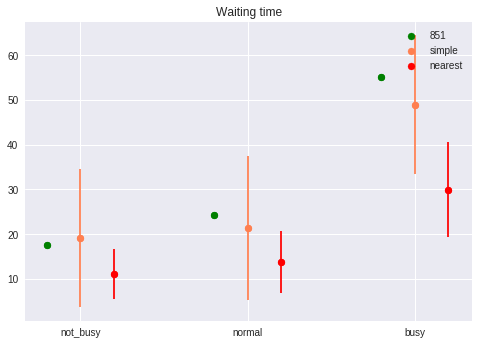

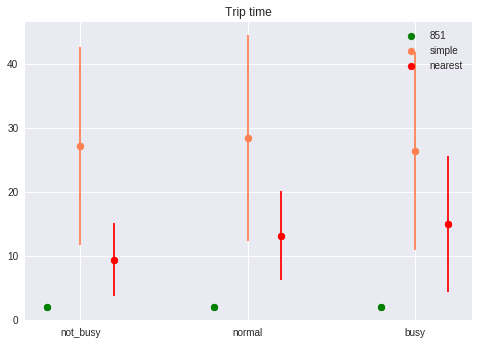

In [0]:
plot_comparative_scatter(avg_data_waiting, name='Waiting time')
plot_comparative_scatter(avg_data_trip, name='Trip time')

## Animation

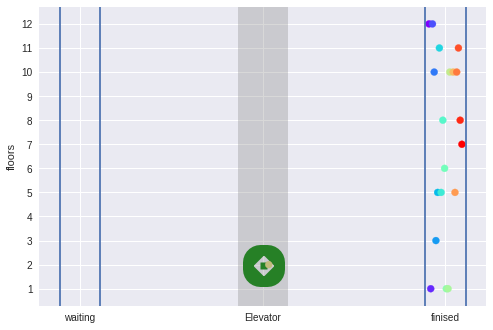

In [0]:
SH=Simulation_handler()
SH.run_simulation(12, 20, 5,'nearest',False)
SH.make_viz()

### Checks and tests

In [0]:
# check initiation of all passengers
building_try1 = Building(num_floors=10, num_passengers=5)

for p in building_try1.all_passengers:
  origin=p.get_origin()
  dest=p.get_dest()
  print (origin, dest)
  assert abs(origin-dest)>1
  stat=p.get_status()
  assert stat==0

7 3
4 6
1 4
5 9
6 2


In [0]:
# check elevator move func
building_try1 = Building(num_floors=10, num_passengers=5)
assert building_try1.elevator.num_floors==building_try1.num_floors
assert building_try1.elevator.in_elevator_passenger_list==[]

building_try1.elevator.set_destination(building_try1.elevator.current_floor+1)

building_try1.elevator.close_doors()
building_try1.elevator.move()

building_try1.elevator.direction
assert building_try1.elevator.direction==building_try1.elevator.UP
assert building_try1.elevator.current_floor==2

In [0]:
# check elevator collect and drop paasengers
building_try1 = Building(num_floors=10, num_passengers=5)
building_try1.elevator.register_passenger(building_try1.all_passengers[0])
assert len(building_try1.elevator.in_elevator_passenger_list)==1
assert building_try1.all_passengers[0].get_status()==1

assert building_try1.elevator.drop_passenger(building_try1.all_passengers[0])==True
assert building_try1.elevator.drop_passenger(building_try1.all_passengers[1])==False

assert building_try1.all_passengers[0].get_status()==2

In [0]:
# check elevator close and open doors
building_try1 = Building(num_floors=10, num_passengers=5)
assert building_try1.elevator.door_open==True

building_try1.elevator.open_doors()
assert building_try1.elevator.door_open==True

building_try1.elevator.close_doors()
assert building_try1.elevator.door_open==False

In [0]:
#check collect and drop all passenger
building_try1 = Building(num_floors=5, num_passengers=5)

for p in building_try1.all_passengers:
  origin=p.get_origin()
  dest=p.get_dest()
  print (origin, dest)

4 1
4 1
4 2
4 1
3 1


In [0]:
#collects
origin = building_try1.all_passengers[0].get_origin()
building_try1.elevator.set_destination(origin)
building_try1.elevator.close_doors()
building_try1.elevator.move()
print ('collecting from floor', origin)

building_try1.collect_all_passengers_in_floor()
print(building_try1.elevator.in_elevator_passenger_list)


for p in building_try1.all_passengers:
  for p_in_elevator in building_try1.elevator.in_elevator_passenger_list:
    if p==p_in_elevator:
      print ('dest:',p.get_dest(),' status:',p.get_status())
      assert p.get_status()==p.in_elevator
  

collecting from floor 4
[<__main__.Passenger object at 0x7f696099ecc0>, <__main__.Passenger object at 0x7f696099e438>, <__main__.Passenger object at 0x7f6960aa6b38>, <__main__.Passenger object at 0x7f6960aa6438>]
dest: 1  status: 1
dest: 1  status: 1
dest: 2  status: 1
dest: 1  status: 1


In [0]:
pass_collected_by_elevator = [i for i in building_try1.elevator.in_elevator_passenger_list]

In [0]:
pass_collected_by_elevator

In [0]:
#drops
dest = building_try1.elevator.in_elevator_passenger_list[0].get_dest()

#print (building_try1.elevator.current_floor, building_try1.elevator.current_destination)
building_try1.elevator.close_doors()
building_try1.elevator.set_destination(dest)
building_try1.elevator.move()

print ('dropping at floor',building_try1.elevator.current_floor)
building_try1.elevator.open_doors()
print(building_try1.drop_all_passengers_in_floor())


#assert dropped_passenger not in building_try1.elevator.in_elevator_passenger_list
n_dropped_pass=0
for p in pass_collected_by_elevator:
  print (p)
  if p.get_dest()==building_try1.elevator.current_floor:
    print (p.get_dest(),p.get_status())
    assert p.get_status()==p.finished

#assert (len(building_try1.elevator.in_elevator_passenger_list)== len(pass_collected_by_elevator)- n_dropped_pass)

dropping at floor 1
[None, None, None]
1 2
1 2
1 2


In [0]:
#simple strategy 
building_try1 = Building(num_floors=5, num_passengers=3)
assert building_try1.all_passengers_done()==False
#while not building_try1.all_passengers_done():
for i in range(20):
  building_try1.elevator_strategy_handler()
#   print ('doors:',building_try1.elevator.door_open)
#   print ('current floor:',building_try1.elevator.current_floor)
#   print ('current dest:', building_try1.elevator.current_destination)
#   print ([i.get_origin() for i in building_try1.awaiting_passengers])
#   print ([i.get_dest() for i in building_try1.elevator.in_elevator_passenger_list])
#   print (building_try1.all_passengers_done())

assert building_try1.all_passengers_done()==True

In [0]:
for p in building_try1.all_passengers:
  print(p.waiting_time, p.trip_time)
  print()

2 6

1 3

0 3

